In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sns
import scipy as sp
import random
from sklearn.linear_model import LogisticRegression
from IPython.core.debugger import set_trace
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import math
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import *
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import cross_val_score

# Exploratory Data Analysis (EDA):

In [ ]:
train = pd.read_csv(r"train.csv")
test = pd.read_csv(r"test.csv")

## Data Cleaning / Removing Outliers - Mihir
Dropped unnecessary columns from the training and test data. Replaced "Sex" column values with 0s (male) and 1s (female) so that the data can be used for correlation analysis. Same was done with "Embarked" with 0s (S), 1s (C), and 2s (Q). 

In [ ]:
train.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
test.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
test["Fare"] = test["Fare"].round()
trainAgeAvg = round(train["Age"].mean())
testAgeAvg = round(test["Age"].mean())

train["Age"] = train["Age"].replace(np.nan, trainAgeAvg)
test["Age"] = test["Age"].replace(np.nan, testAgeAvg)

train['Sex'].replace(['male', 'female'],[0, 1], inplace=True)
test['Sex'].replace(['male', 'female'],[0, 1], inplace=True)
train['Embarked'].replace(['S', 'C', 'Q'],[0, 1, 2], inplace=True)
test['Embarked'].replace(['S', 'C', 'Q'],[0, 1, 2], inplace=True)

train["Embarked"] = train["Embarked"].replace(np.nan, random.randint(0, 2))
# test["Embarked"] = test["Embarked"].replace(np.nan, 0)

# train[(np.abs(sp.stats.zscore(train)) < 3).all(axis=1)]

Removed all outliers by determining the z-score values of all the data based on the age and fare values. All rows that have a zscore value greater than 2.5 are removed from the dataset. 

In [ ]:
train_adj = train[["Age", "Fare"]]

z = sp.stats.zscore(train_adj)
abs_z = np.abs(z)

filtered = (abs_z < 2.5).all(axis=1)
train = train[filtered]
# filtered_entries
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0.0
1,2,1,1,1,38.0,1,0,71.2833,1.0
2,3,1,3,1,26.0,0,0,7.9250,0.0
3,4,1,1,1,35.0,1,0,53.1000,0.0
4,5,0,3,0,35.0,0,0,8.0500,0.0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0.0
887,888,1,1,1,19.0,0,0,30.0000,0.0
888,889,0,3,1,30.0,1,2,23.4500,0.0
889,890,1,1,0,26.0,0,0,30.0000,1.0


## Socio-economic Trends - Sid

### Age vs. Fare Value
Here's a scatter plot that maps the age of each passenger to the fare value. Based on the scatter plot, we can see a general concentration of increased fare value in the age range from 20 to 40 years. 

Text(0, 0.5, 'Fare Value in Dollars')

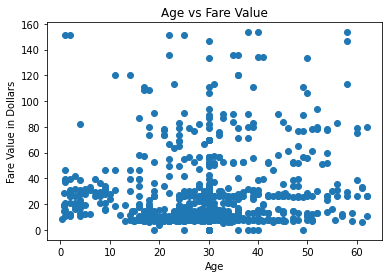

In [ ]:
mp.pyplot.scatter(train["Age"], train["Fare"])
mp.pyplot.title("Age vs Fare Value")
mp.pyplot.xlabel("Age")
mp.pyplot.ylabel("Fare Value in Dollars")

### Number of Siblings/Spouses vs. Fare Price
Got the maximum number of sibilings/spouses and iterated through a loop that added the median values of all of the number of sibling/spouses in the dataset to a list along with an index with all of the possible sibling/spouses to another list. Then, the medians were plotted onto a bar graph. Based on the graph, as the number of sibling/spouses increase, the fare price increases, showing a positive correlation. 

Text(0, 0.5, 'Median Fare Value')

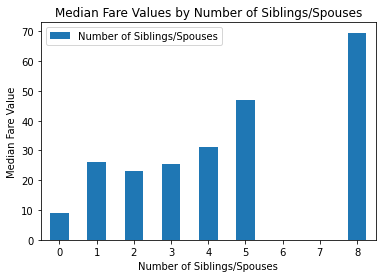

In [ ]:
max = train["SibSp"].max()

sibFareVals = []
index = []
for i in range(max+1):
  sibFareVals.append(train[train['SibSp'] == i]['Fare'].median())
  index.append(str(i))

df = pd.DataFrame({'Number of Siblings/Spouses': sibFareVals}, index=index)
ax = df.plot.bar(rot=0)
mp.pyplot.title("Median Fare Values by Number of Siblings/Spouses")
mp.pyplot.xlabel("Number of Siblings/Spouses")
mp.pyplot.ylabel("Median Fare Value")

### Number of Parents/Children vs. Fare Price
Got the maximum number of parents/children and iterated through a loop that added the median values of all of the number of parents/children in the dataset to a list along with an index with all of the possible parents/children to another list. Then, the medians were plotted onto a bar graph. Based on the graph, as the number of parents/children increase, the fare price generally increases, showing a positive correlation. 

Text(0, 0.5, 'Median Fare Value')

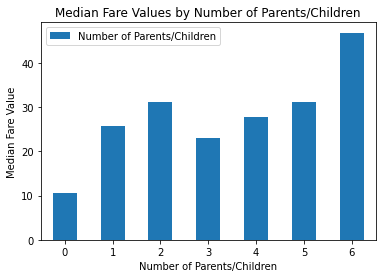

In [ ]:
max = train["Parch"].max()

sibFareVals = []
index = []
for i in range(max+1):
  sibFareVals.append(train[train['Parch'] == i]['Fare'].median())
  index.append(str(i))

df = pd.DataFrame({'Number of Parents/Children': sibFareVals}, index=index)
ax = df.plot.bar(rot=0)
mp.pyplot.title("Median Fare Values by Number of Parents/Children")
mp.pyplot.xlabel("Number of Parents/Children")
mp.pyplot.ylabel("Median Fare Value")

### Pclass vs. Fare Price
Got the maximum number of classes and iterated through a loop that added the median fare values of all of the classes in the dataset to a list along with an index with all of the possible classes to another list. Then, the medians were plotted onto a bar graph. Based on the graph, as the class number increases, the fare price decreases, showing a positive correlation. This makes sense because first class should be the costliest while the lowest class, third class, is the cheapest. 

Text(0, 0.5, 'Median Fare Value')

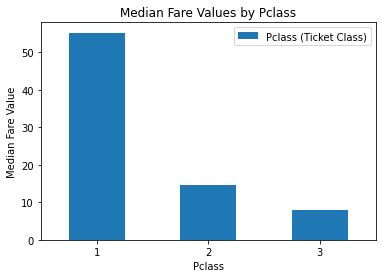

In [ ]:
max = train["Pclass"].max()

pclassFareVals = []
index = []
for i in range(max+1):
  if i > 0:
    pclassFareVals.append(train[train['Pclass'] == i]['Fare'].median())
    index.append(str(i))

df = pd.DataFrame({'Pclass (Ticket Class)': pclassFareVals}, index=index)
ax = df.plot.bar(rot=0)
mp.pyplot.title("Median Fare Values by Pclass")
mp.pyplot.xlabel("Pclass")
mp.pyplot.ylabel("Median Fare Value")

### Sex vs. Fare Price
Since Sex only has two possibilities, 0 and 1, there's no need to calculate the maximum number and iterate. The average values are calculated accordingly and plotted to a bar graph. Based on the bar graph, females had to pay a higher fare than men. 

Text(0, 0.5, 'Average Fare Value')

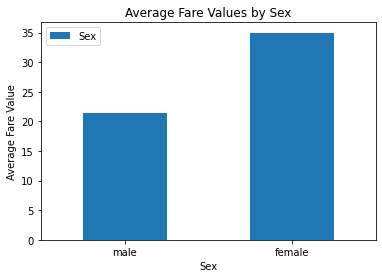

In [ ]:
maleAvgFare = train[train['Sex'] == 0]['Fare'].mean()
femaleAvgFare = train[train['Sex'] == 1]['Fare'].mean()

avgFareVals = [maleAvgFare, femaleAvgFare]

index = ['male', 'female']

df = pd.DataFrame({'Sex': avgFareVals}, index=index)
ax = df.plot.bar(rot=0)
mp.pyplot.title("Average Fare Values by Sex")
mp.pyplot.xlabel("Sex")
mp.pyplot.ylabel("Average Fare Value")

### Port Embarked vs. Fare Price
Since Embarked only has three possibilities, 0, 1, and 2, there's no need to calculate the maximum number and iterate. The average values are calculated accordingly and plotted to a bar graph. Based on the bar graph, people who embarked from Cherbourg had the highest fare and those that embarked from Queestown had the lowest fare. 

Text(0, 0.5, 'Average Fare Value')

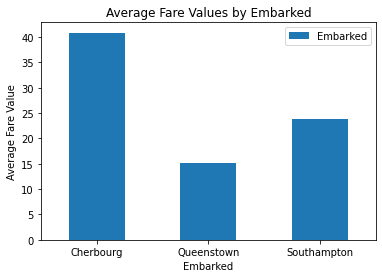

In [ ]:
cAvgFare = train[train['Embarked'] == 1]['Fare'].mean()
qAvgFare = train[train['Embarked'] == 2]['Fare'].mean()
sAvgFare = train[train['Embarked'] == 0]['Fare'].mean()

embarkedFareVals = [cAvgFare, qAvgFare, sAvgFare]
index = ['Cherbourg', 'Queenstown', 'Southampton']

df = pd.DataFrame({'Embarked': embarkedFareVals}, index=index)
ax = df.plot.bar(rot=0)
mp.pyplot.title("Average Fare Values by Embarked")
mp.pyplot.xlabel("Embarked")
mp.pyplot.ylabel("Average Fare Value")

We used non-numerical like "Embarked" and "Sex" to extrapolate information about the socio-economic demographics of the people on the Titanic. To restate the information we extracted previously, we determined that females paid a high fare price than males and the fare prices increased from people who embarked from Queenstown, Southampton, and Cherbourg, respectively. 

## Survival Victims Trends - Sid

### Distribution of Survival Victims in Relation to Gender
A bar graph was plotted that displays males that didn't survive, males that survived, females that didn't survive, and females that survived. Based on the graph, most of the males did not survive while more females survived compared to men. In fact, more females survived than males did on the Titanic. 

Text(0, 0.5, 'Number of People Survived/Not Survived ')

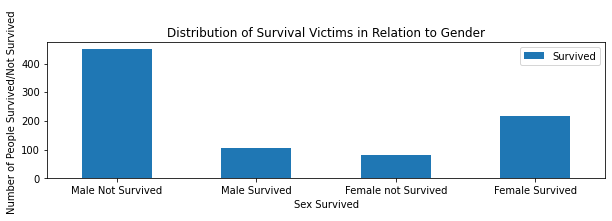

In [ ]:
not_survived = train[train['Survived'] == 0]
survived = train[train['Survived'] == 1]

male_not_survived = not_survived[not_survived['Sex'] == 0].shape[0]
male_survived = survived[survived['Sex'] == 0].shape[0]

female_not_survived = not_survived[not_survived['Sex'] == 1].shape[0]
female_survived = survived[survived['Sex'] == 1].shape[0]

survived_numbers = [male_not_survived, male_survived, female_not_survived, female_survived]
survived_names = ['Male Not Survived', 'Male Survived', 'Female not Survived', 'Female Survived']

df = pd.DataFrame({'Survived': survived_numbers}, index=survived_names)
ax = df.plot.bar(rot=0, figsize=(10, 2.5))
mp.pyplot.title("Distribution of Survival Victims in Relation to Gender")
mp.pyplot.xlabel("Sex Survived")
mp.pyplot.ylabel("Number of People Survived/Not Survived ")

### Distribution of Survival Victims in Relation to Pclass
A bar graph was plotted that displays 1st class people that survived, 1st class people that didn't survive, 2nd class people that survived, 2nd class people that didn't survive, 3rd class people that survived, and 3rd class people that didn't survive. Based on the data, the majority of people that did not survive were people from the 3rd class. Another interesting detail is that in terms of percentage, a greater percent of 1st class people survived and as we go to the 2nd and 3rd class, the percentage of people that survive consistently decrease. 

Text(0, 0.5, 'Number of People Survived ')

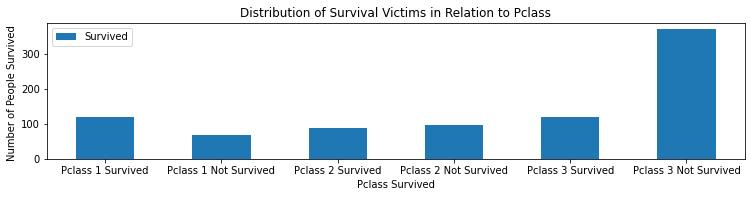

In [ ]:
not_survived = train[train['Survived'] == 0]
survived = train[train['Survived'] == 1]

p1_survived = survived[survived['Pclass'] == 1].shape[0]
p1_not_survived = not_survived[not_survived['Pclass'] == 1].shape[0]

p2_survived = survived[survived['Pclass'] == 2].shape[0]
p2_not_survived = not_survived[not_survived['Pclass'] == 2].shape[0]

p3_survived = survived[survived['Pclass'] == 3].shape[0]
p3_not_survived = not_survived[not_survived['Pclass'] == 3].shape[0]

survived_numbers = [p1_survived, p1_not_survived, p2_survived, p2_not_survived,
                    p3_survived, p3_not_survived]
survived_names = ['Pclass 1 Survived', 'Pclass 1 Not Survived', 'Pclass 2 Survived', 
                  'Pclass 2 Not Survived', 'Pclass 3 Survived', 'Pclass 3 Not Survived']

df = pd.DataFrame({'Survived': survived_numbers}, index=survived_names)
ax = df.plot.bar(rot=0, figsize=(12.5, 2.5))
mp.pyplot.title("Distribution of Survival Victims in Relation to Pclass")
mp.pyplot.xlabel("Pclass Survived")
mp.pyplot.ylabel("Number of People Survived ")

### Distribution of Survival Victims in Relation to Age
A bar graph was plotted that displays those from ages 0-25 that survived, 0-25 that didn't survive, 25-50 that survived, 25-50 that didn't survive, 50+ that survived, and 50+ that didn't survive. Based on the data, the majority of people that surived, in terms of numbers, were from ages 0-20 and 25-50. However, in terms of percentages, there isn't a significant increase. This is mostly due to the pclass of the people. From the beginning, we observed that those who had a higher fare, therefore a higher class, were concentrated in 20 to 50. 

Text(0, 0.5, 'Number of People Survived ')

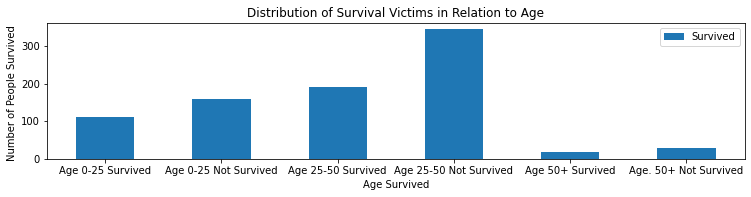

In [ ]:
not_survived = train[train['Survived'] == 0]
survived = train[train['Survived'] == 1]

age1_survived = survived[survived['Age'] < 25].shape[0]
age1_not_survived = not_survived[not_survived['Age'] < 25].shape[0]

age2_survived = survived[survived['Age'].between(25, 50)].shape[0]
age2_not_survived = not_survived[not_survived['Age'].between(25, 50)].shape[0]

age3_survived = survived[survived['Age'] > 50].shape[0]
age3_not_survived = not_survived[not_survived['Age'] > 50].shape[0]

survived_numbers = [age1_survived, age1_not_survived, age2_survived, age2_not_survived,
                    age3_survived, age3_not_survived]
survived_names = ['Age 0-25 Survived', 'Age 0-25 Not Survived', 'Age 25-50 Survived', 
                  'Age 25-50 Not Survived', 'Age 50+ Survived', 'Age. 50+ Not Survived']

df = pd.DataFrame({'Survived': survived_numbers}, index=survived_names)
ax = df.plot.bar(rot=0, figsize=(12.5, 2.5))
mp.pyplot.title("Distribution of Survival Victims in Relation to Age")
mp.pyplot.xlabel("Age Survived")
mp.pyplot.ylabel("Number of People Survived ")

## Correlation Analysis - Sid
A correlation analysis was done on all of the features and some interesting results were shown. Based on the data, the strong positive correlation we found was between those that survived and sex. The people that survived were mostly female. This makes sense because when the Titanic was sinking, they gave priority to women and children. The strongest negative correlation we found was between pclass and fare. This supports the bar graph we created earlier that showed the relationship between fare and pclass. As the classes go from 1st to 3rd class, the prices should decrease. Other important details that are worth mentioning are the correlations between survived and pclass, survived and fare, survived and embarked port, age and parch, sibsp and parch, sex and fare, sibsp and fare, and parch and fare. This concludes that based on the high correlation values, these factors may have made a difference in surviving the Titanic versus not suriviving. 

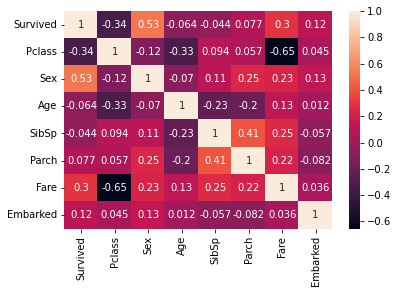

In [ ]:
pearson_columns = train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
corr = pearson_columns.corr()
sns.heatmap(corr, annot=True)


# Modeling:

Using the correlation analysis, we determined what our first set of features will be for our models Logistic Regression, Naive Bayes, and the KNearest Neighbors Algorithm. We looked through each one of the most correlated features to survival and added them one by one to extract them from the training data set and checked to see if the F1-score increased or decreased as we added each feature. For each one of the data sets we split the data 75% training and 25% testing and also removed random selection so we can better compare the results from each model evenly. 

## Logistic Regression - Sid
We use the features that have a high correlation to optimize the model and use a test size of 0.25. Based on the classification report, we received great results. With an f1-score of 0.87 for those that didn't survive, the model was well-fitted to the data while an f1-score of 0.73 for those that survived, although lower than those that didn't survive, is still a good f1-score. A precision of 0.85 shows that the model is not only accurate but also contains precision. A recall of 0.90 on predicting those that didn't survive (0) shows that the model is good at predicting those that didn't survive but a recall of 0.68 on predicting those that did survive (1) shows that the model isn't very accurate at predicting those that survived. An overall accuracy of 0.83 tells us that the model for predicting those that survived/did not survive is very accurate. 

In [ ]:
x = train[["Pclass", "Age", "Parch", "Fare", "Sex", "Embarked"]]
y = train["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, shuffle=False)

# here we are training a Linear regression model against the x and y training data
# increased the max iterations so that it doesn't get stuck in a local minimum in convergence
model = LogisticRegression(max_iter=300)
model.fit(x, y)

predictions = model.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       141
           1       0.78      0.68      0.73        73

    accuracy                           0.83       214
   macro avg       0.81      0.79      0.80       214
weighted avg       0.82      0.83      0.82       214



## Naive Bayes - Mihir


For Naive Bayes, we did the same feature selection algorithm the same way we did for Logisitc Regression. We kept adding the most corelated features and checked to see when the f1-score started to peak. From this, we received the four features being PClass, Fare, Sex, and Embarked. The Naive Bayes model had an accuracy of .79 where it guessed True Positive and True Negative over all prediction 79 percent of the time correctly. We have an average for precision and recall being .79 and .76 respectively. Finally, it has an f1 of .79 as well for the weighted average. If you see from the previous classifier, this classifier too best predicts Not survived over survived data points.

In [ ]:
x = train[["Pclass", "Fare", "Sex", "Embarked"]]
y = train["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, shuffle=False)

gnb = GaussianNB()

nb_pred = gnb.fit(x_train, y_train).predict(x_test)
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       141
           1       0.68      0.70      0.69        73

    accuracy                           0.79       214
   macro avg       0.76      0.76      0.76       214
weighted avg       0.79      0.79      0.79       214



## KNearest Neighbors Algorithm - Mihir

For K Nearest Neighbors, we did the same feature selection algorithm the same way we did for Logisitc Regression. We kept adding the most corelated features and checked to see when the f1-score started to peak. From this, we received the four features being PClass, Fare, Sex, and Embarked. The K Nearest Neighbor model had an accuracy of .8 where it guessed True Positive and True Negative over all prediction 79 percent of the time correctly. We have an average for precision and recall being .8 and .8 respectively. Finally, it has an f1 of .79 as well for the weighted average. If you see from the previous classifier, this classifier too best predicts Not survived over survived data points.

In [ ]:
x = train[["Pclass", "Fare", "Sex", "Embarked"]]
y = train["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, shuffle=False)

neigh = KNeighborsClassifier(n_neighbors=7)

neigh_pred = neigh.fit(x_train, y_train).predict(x_test)
print(classification_report(y_test, neigh_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       141
           1       0.76      0.60      0.67        73

    accuracy                           0.80       214
   macro avg       0.79      0.75      0.76       214
weighted avg       0.80      0.80      0.79       214



## Improving upon the previous models - Mihir

To check our results and f1-scores from past data to see if they are indeed efficient with features that we selected, we added a feature selection in SelectKBest features. SelectKBest selects the k best features that are ideal and that will optimize the f1-score. For each one of the classifiers above, we added a feature selector into a Pipeline object and see how it performs. For each one of the classifiers, there was no improvement seen. The only improvement we saw with a small bump in the average f1-score is in Logistic Regression. However this was only tested on one set of data, we need to perform cross validation on this 

In [ ]:
x = train[["Pclass", "Fare", "Sex", "Age", "SibSp", "Embarked", "Parch"]]
y = train["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, shuffle=False)

pipe_lg = Pipeline([('red', SelectKBest(chi2, k=6)),
                 ('clf', LogisticRegression(max_iter=300))])

pipe_lg.fit(x_train, y_train)
pred_lg = pipe_lg.predict(x_test)
print(classification_report(y_test, pred_lg))


              precision    recall  f1-score   support

           0       0.85      0.90      0.88       141
           1       0.78      0.70      0.74        73

    accuracy                           0.83       214
   macro avg       0.82      0.80      0.81       214
weighted avg       0.83      0.83      0.83       214



In [ ]:
pipe_nb = Pipeline([('red', SelectKBest(chi2, k=5)),
                 ('clf', GaussianNB())])

pipe_nb.fit(x_train, y_train)
pred_nb = pipe_nb.predict(x_test)
print(classification_report(y_test, pred_nb))


              precision    recall  f1-score   support

           0       0.83      0.84      0.84       141
           1       0.69      0.67      0.68        73

    accuracy                           0.79       214
   macro avg       0.76      0.76      0.76       214
weighted avg       0.78      0.79      0.78       214



In [ ]:
pipe_ne = Pipeline([('red', SelectKBest(chi2, k=5)),
                 ('clf', KNeighborsClassifier(n_neighbors=7))])

pipe_ne.fit(x_train, y_train)
pred_ne = pipe_nb.predict(x_test)
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       141
           1       0.69      0.67      0.68        73

    accuracy                           0.79       214
   macro avg       0.76      0.76      0.76       214
weighted avg       0.78      0.79      0.78       214



## Cross-Validation - Mihir

By using the function `cross_val_score()`, I am allowed to get an average and standard devation over multiple train test splits for the f1-score. From each one of the scores shown in the bottom, we can see it varies on whether the classifiers improved with SelectKBest method. For Logistic Regression, F1-score had the same mean with +/- .01 for std. For Naive Bayes, the model without the SelectKBest had the higher mean. For K Nearest Neighbors, the model with the SelectKBest function had the mean f1-score.






In [ ]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=8, test_size=0.25, random_state=0)

score_lg = cross_val_score(model, x, y, cv=cv, scoring="f1_macro")
score_k_lg = cross_val_score(pipe_lg, x, y, cv=cv, scoring="f1_macro")

for i in range(len(score_lg)):
    print("Cross Validation Split %x: %0.2f" % ((i + 1), score_lg[i]))

print("\n")

for i in range(len(score_k_lg)):
    print("Cross Validation Split %x with SelectKBest Algorithm: %0.2f" % ((i + 1), score_k_lg[i]))

print("\n")

print("%0.2f f1-score with a standard deviation of %0.2f for Logistic Regression" % (score_lg.mean(), score_lg.std()))
print("%0.2f f1-score with a standard deviation of %0.2f for Logistic Regression with SelectKBest" % (score_k_lg.mean(), score_k_lg.std()))

Cross Validation Split 1: 0.79
Cross Validation Split 2: 0.78
Cross Validation Split 3: 0.81
Cross Validation Split 4: 0.71
Cross Validation Split 5: 0.74
Cross Validation Split 6: 0.78
Cross Validation Split 7: 0.80
Cross Validation Split 8: 0.75


Cross Validation Split 1 with SelectKBest Algorithm: 0.78
Cross Validation Split 2 with SelectKBest Algorithm: 0.77
Cross Validation Split 3 with SelectKBest Algorithm: 0.77
Cross Validation Split 4 with SelectKBest Algorithm: 0.72
Cross Validation Split 5 with SelectKBest Algorithm: 0.75
Cross Validation Split 6 with SelectKBest Algorithm: 0.79
Cross Validation Split 7 with SelectKBest Algorithm: 0.79
Cross Validation Split 8 with SelectKBest Algorithm: 0.75
0.77 f1-score with a standard deviation of 0.03 for Logistic Regression
0.77 f1-score with a standard deviation of 0.02 for Logistic Regression with SelectKBest


In [ ]:
score_lg = cross_val_score(gnb, x, y, cv=cv, scoring="f1_macro")
score_k_lg = cross_val_score(pipe_nb, x, y, cv=cv, scoring="f1_macro")

for i in range(len(score_lg)):
    print("Cross Validation Split %x: %0.2f" % ((i + 1), score_lg[i]))

print("\n")

for i in range(len(score_k_lg)):
    print("Cross Validation Split %x with SelectKBest Algorithm: %0.2f" % ((i + 1), score_k_lg[i]))

print("\n")

print("%0.2f f1-score with a standard deviation of %0.2f for Naive Bayes" % (score_lg.mean(), score_lg.std()))
print("%0.2f f1-score with a standard deviation of %0.2f for Naive Bayes with SelectKBest" % (score_k_lg.mean(), score_k_lg.std()))

Cross Validation Split 1: 0.79
Cross Validation Split 2: 0.73
Cross Validation Split 3: 0.78
Cross Validation Split 4: 0.71
Cross Validation Split 5: 0.73
Cross Validation Split 6: 0.75
Cross Validation Split 7: 0.77
Cross Validation Split 8: 0.73


Cross Validation Split 1 with SelectKBest Algorithm: 0.79
Cross Validation Split 2 with SelectKBest Algorithm: 0.71
Cross Validation Split 3 with SelectKBest Algorithm: 0.76
Cross Validation Split 4 with SelectKBest Algorithm: 0.68
Cross Validation Split 5 with SelectKBest Algorithm: 0.74
Cross Validation Split 6 with SelectKBest Algorithm: 0.75
Cross Validation Split 7 with SelectKBest Algorithm: 0.76
Cross Validation Split 8 with SelectKBest Algorithm: 0.74


0.75 f1-score with a standard deviation of 0.03 for Naive Bayes
0.74 f1-score with a standard deviation of 0.03 for Naive Bayes with SelectKBest


In [ ]:
score_lg = cross_val_score(neigh, x, y, cv=cv, scoring="f1_macro")
score_k_lg = cross_val_score(pipe_ne, x, y, cv=cv, scoring="f1_macro")

for i in range(len(score_lg)):
    print("Cross Validation Split %x: %0.2f" % ((i + 1), score_lg[i]))

print("\n")

for i in range(len(score_k_lg)):
    print("Cross Validation Split %x with SelectKBest Algorithm: %0.2f" % ((i + 1), score_k_lg[i]))

print("\n")

print("%0.2f f1-score with a standard deviation of %0.2f for K-Nearest Neighbors" % (score_lg.mean(), score_lg.std()))
print("%0.2f f1-score with a standard deviation of %0.2f for K-Nearest Neighbors with SelectKBest" % (score_k_lg.mean(), score_k_lg.std()))

Cross Validation Split 1: 0.71
Cross Validation Split 2: 0.63
Cross Validation Split 3: 0.63
Cross Validation Split 4: 0.69
Cross Validation Split 5: 0.63
Cross Validation Split 6: 0.64
Cross Validation Split 7: 0.69
Cross Validation Split 8: 0.63


Cross Validation Split 1 with SelectKBest Algorithm: 0.71
Cross Validation Split 2 with SelectKBest Algorithm: 0.62
Cross Validation Split 3 with SelectKBest Algorithm: 0.70
Cross Validation Split 4 with SelectKBest Algorithm: 0.69
Cross Validation Split 5 with SelectKBest Algorithm: 0.74
Cross Validation Split 6 with SelectKBest Algorithm: 0.67
Cross Validation Split 7 with SelectKBest Algorithm: 0.69
Cross Validation Split 8 with SelectKBest Algorithm: 0.63


0.66 f1-score with a standard deviation of 0.03 for K-Nearest Neighbors
0.68 f1-score with a standard deviation of 0.04 for K-Nearest Neighbors with SelectKBest


# Conclusion

In conclusion, using correlation matrix to determine which features would work or SelectKBest function for each classifier was very varied in its results and as a result we can see how it varies when we ran the Cross Validation. We saw that whichever method we used depended on the classifier we applied it to. The classifier that had the most success regardless of the method used for finding which features to implement is Logisitic Regression. Logistic Regression had an average of .77 f1-score over 8 different splits of the data compared around .74/.75 for Naive Bayes and .66/.68 for K-Nearest Neighbors.